In [ ]:
import glob
from tqdm.auto import tqdm
from vtk.util.numpy_support import vtk_to_numpy
import vtk
import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from scipy.optimize import linear_sum_assignment
from collections import defaultdict

subjects = [i.split('\\')[-2] for i in glob.glob("PATH")]


### Utility Functions

In [36]:
def aggregate_grids_with_unique_labels_3d(grids_dict):
    # Collect all unique labels, excluding empty strings
    labels_set = set()
    for grid in grids_dict.values():
        labels_set.update(label for label in grid.flatten() if label != '')
    labels = list(labels_set)
    n_labels = len(labels)
    
    # Map labels to indices
    label_to_index = {label: idx for idx, label in enumerate(labels)}
    index_to_label = {idx: label for idx, label in enumerate(labels)}
    
    # Get grid shape
    grid_shape = next(iter(grids_dict.values())).shape  # Should be (x, y, z)
    n_positions = grid_shape[0] * grid_shape[1] * grid_shape[2]
    
    # Map positions to indices
    positions = [(i, j, k) for i in range(grid_shape[0]) 
                            for j in range(grid_shape[1]) 
                            for k in range(grid_shape[2])]
    position_to_index = {(i, j, k): idx for idx, (i, j, k) in enumerate(positions)}
    index_to_position = {idx: (i, j, k) for idx, (i, j, k) in enumerate(positions)}
    
    # Build cost matrix of size (n_labels x n_positions)
    cost_matrix = np.zeros((n_labels, n_positions))
    
    # For each label and position, compute the negative count
    for grid in grids_dict.values():
        for i in range(grid_shape[0]):
            for j in range(grid_shape[1]):
                for k in range(grid_shape[2]):
                    label = grid[i, j, k]
                    if label != '':
                        label_idx = label_to_index[label]
                        pos_idx = position_to_index[(i, j, k)]
                        cost_matrix[label_idx, pos_idx] -= 1  # Negative count (since we minimize cost)
        
    # Use linear_sum_assignment to find the assignment
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Build the aggregated grid
    aggregated_grid = np.empty(grid_shape, dtype=object)
    aggregated_grid[:] = ''
    
    for label_idx, pos_idx in zip(row_ind, col_ind):
        label = index_to_label[label_idx]
        i, j, k = index_to_position[pos_idx]
        aggregated_grid[i, j, k] = label
    
    return aggregated_grid

def get_centroid(file):
    '''
    Get the centroid of a VTP file

    Parameters
    ----------
    file : str
        The path to the VTP file

    Returns
    -------
    middle : np.array
        The centroid of the VTP file
    '''
    # Create a VTK reader for VTP files
    reader = vtk.vtkXMLPolyDataReader()
    reader.SetFileName(file)  # Replace with your VTP file path
    reader.Update()  # Read the file

    # Get the voxel grid points from the VTP file
    polydata = reader.GetOutput()
    points = polydata.GetPoints()
    array = points.GetData()
    point_coordinates = vtk_to_numpy(array)

    ## Get the middle of point_coordinates
    middle = point_coordinates.mean(axis=0)

    return middle

def arrange_grid_points(grid_points_dict, grid_size=5):
    '''
    Given a dictionary of points and their desired positions, this function
    arranges the points in a grid layout using the Hungarian algorithm.

    Parameters
    ----------
    grid_points_dict : dict
        A dictionary where the keys are grid cells and the values are lists
        of tuples. Each tuple contains the name of a point and its desired
        position.

    grid_size : int

    Returns
    -------
    new_grid : dict
        A dictionary where the keys are grid cells and the values are lists
        of tuples. Each tuple contains the name of a point and its new position
    '''

    # Step 1: Extract points and their desired positions
    points = []
    for grid_cell, point_list in grid_points_dict.items():
        for tract_name, position in point_list:
            points.append((tract_name, position))

    if not points:
        return {}

    desired_positions = np.array([position for _, position in points])
    tract_names = [tract_name for tract_name, _ in points]

    # Step 2: Define the grid positions in normalized coordinates
    grid_indices = [(i, j, k) for i in range(grid_size) for j in range(grid_size) for k in range(grid_size)]
    grid_positions = {}
    for i, j, k in grid_indices:
        x = i / (grid_size - 1)
        y = j / (grid_size - 1)
        z = k / (grid_size - 1)
        grid_positions[(i, j, k)] = np.array([x, y, z])

    # Step 3: Build the cost matrix (distance between desired positions and grid positions)
    grid_positions_array = np.array([pos for pos in grid_positions.values()])
    cost_matrix = cdist(desired_positions, grid_positions_array, metric='euclidean')

    # Step 4: Use the Hungarian algorithm to assign points to grid positions
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Step 5: Build the new grid arrangement
    new_grid = {grid_cell: [] for grid_cell in grid_indices}
    for point_idx, grid_idx in zip(row_ind, col_ind):
        tract_name = tract_names[point_idx]
        grid_cell = list(grid_positions.keys())[grid_idx]
        position = desired_positions[point_idx]
        new_grid[grid_cell] = [(tract_name, position)]

    return new_grid

In [ ]:
subject_wise_centroids = {}
for s in tqdm(subjects):
    try:
        files=glob.glob(f"../Dataset/NEUROFIT_diffusion/DTI_wma/{s}/*.vtp")
        centroids = {i.split('\\')[-1].split('.')[0]:get_centroid(i) for i in files}
        subject_wise_centroids[s] = centroids
    except:
        pass

In [5]:
## Save the subject_wise_centroids
import pickle 
with open("../Dataset/NEUROFIT_diffusion/subject_wise_centroids.pkl", "wb") as f:
    pickle.dump(subject_wise_centroids, f)


### Getting the representations

In [4]:
## Load the subject_wise_centroids
import pickle
with open("../Dataset/NEUROFIT_diffusion/subject_wise_centroids.pkl", "rb") as f:
    subject_wise_centroids = pickle.load(f)
    

In [5]:
# full_dataframe = []
# for i,(keys,values) in enumerate(subject_wise_centroids.items()):
#     dataframe = pd.DataFrame({i:str(tuple(j)) for i,j in values.items()}, index=[i])
#     dataframe['subject'] = keys
#     full_dataframe.append(dataframe)

# full_dataframe = pd.concat(full_dataframe)
# full_dataframe.iloc[:,::-1].to_csv('../Dataset/NEUROFIT_diffusion/centroid.csv')

In [ ]:
subject_wise_grids = dict()
for s in tqdm(subject_wise_centroids.keys()): 
    points_3d = np.array([list(i) for i in subject_wise_centroids[s].values()])
    tract_names = list(subject_wise_centroids[s].keys())

    ### Multi Dimensional Scaling
    min_vals = points_3d.min(axis=0)
    max_vals = points_3d.max(axis=0)
    normalized_points = (points_3d - min_vals) / (max_vals - min_vals)
    grid_points = normalized_points * (5 - 1)
    overlaping_grid_indices = list(zip(tract_names, np.round(grid_points).astype(int), normalized_points))

    ## Get a dictionary of all possible grid points
    grid_points_dict = {}
    for i in range(5):
        for j in range(5):
            for k in range(5):
                grid_points_dict[(i, j, k)] = [(coord[0], coord[2]) for coord in overlaping_grid_indices if tuple(coord[1]) == (i, j, k)]
                ## Assign all overlaping grid indices to the grid points

    rearranged = arrange_grid_points(grid_points_dict)

    grid = np.full((5, 5, 5), "", dtype=object)
    for (x, y, z),n in rearranged.items():
        try:
            grid[x, y, z] = n[0][0]
        except:
            pass
        
    try:
        subject_wise_grids[s] = grid
    except:
        pass
    

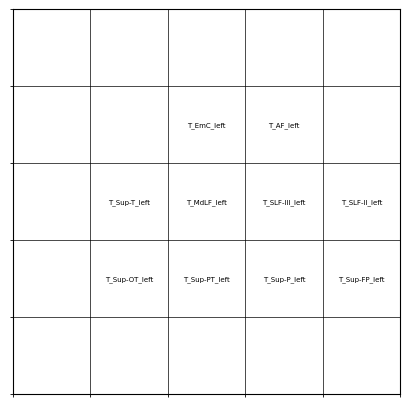

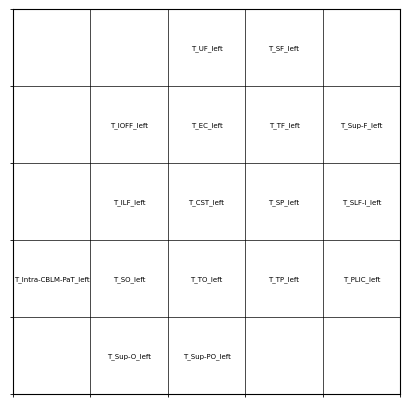

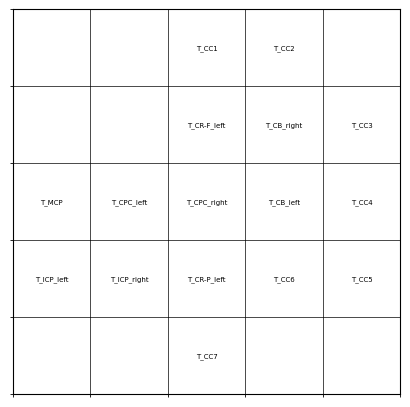

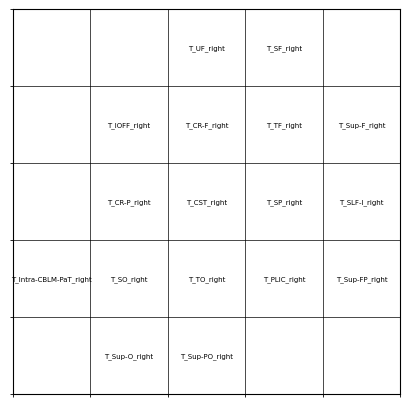

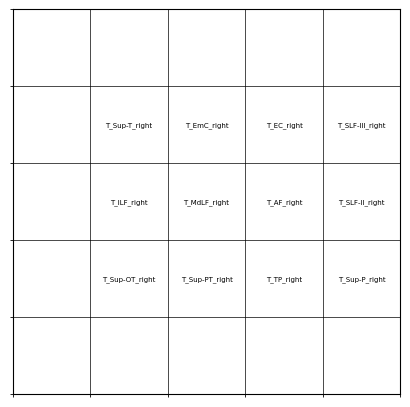

In [35]:
grid = subject_wise_grids['sub-NEUROFIT_014']

for layer in range(grid.shape[2]):
    ## Plot a 3D numpy array grid as slices from top to bottom 
    fig, ax = plt.subplots(figsize=(5, 5))

    # Creating the table-like plot using text
    for (i, j), val in np.ndenumerate(grid[layer]):
        ax.text(j, i, val, ha='center', va='center', fontsize=5)

    # Setting the grid lines
    ax.set_xticks(np.arange(-0.5, grid.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, grid.shape[0], 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)

    # Hiding the ticks and labels
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    plt.show()

### Aggreagate

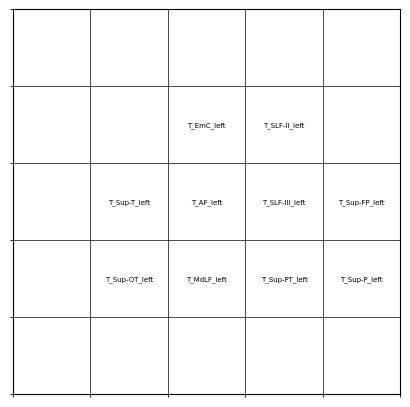

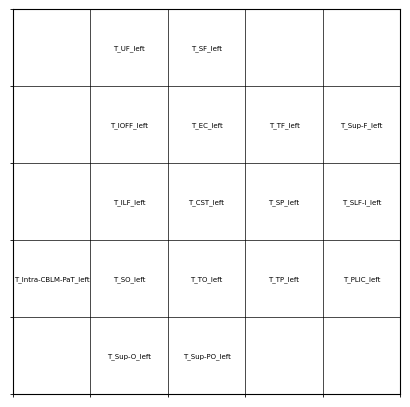

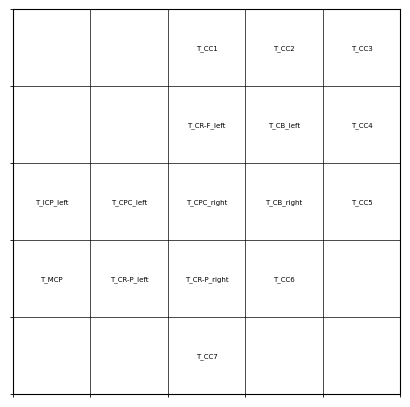

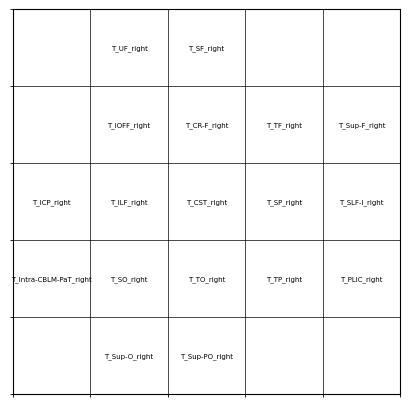

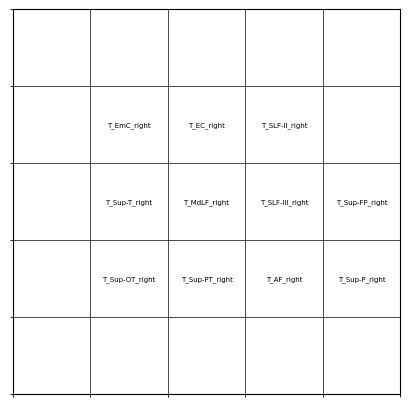

In [40]:
grid = aggregate_grids_with_unique_labels_3d(subject_wise_grids)

for layer in range(grid.shape[2]):
    ## Plot a 3D numpy array grid as slices from top to bottom 
    fig, ax = plt.subplots(figsize=(5, 5))

    # Creating the table-like plot using text
    for (i, j), val in np.ndenumerate(grid[layer]):
        ax.text(j, i, val, ha='center', va='center', fontsize=5)

    # Setting the grid lines
    ax.set_xticks(np.arange(-0.5, grid.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, grid.shape[0], 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)

    # Hiding the ticks and labels
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    plt.show()

In [ ]:
## Save final aggregated grid in Dataset folder as npy file
np.save("PATH/aggregated_grid_3D.npy", grid)